<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x35_%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E7%9A%84%E4%BB%8E%E9%9B%B6%E5%BC%80%E5%A7%8B%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在本节中，我们将从零开始实现一个基于字符级循环神经网络的语言模型，并在周杰伦专辑歌词数据集上训练一个模型来进行歌词创作。首先，我们读取周杰伦专辑歌词数据集：

In [ ]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import math
import numpy as np
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dive_Into_Deep_Learning/')
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Feb 23 13:09:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   1024MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

## 1.one-hot向量
为了将词表示成向量输入到神经网络，一个简单的办法是使用one-hot向量。假设词典中不同字符的数量为NN（即词典大小vocab_size），每个字符已经同一个从0到N−1的连续整数值索引一一对应。如果一个字符的索引是整数i, 那么我们创建一个全0的长为N的向量，并将其位置为i的元素设成1。该向量就是对原字符的one-hot向量。下面分别展示了索引为0和2的one-hot向量，向量长度等于词典大小。

In [ ]:
# 自己实现的one-hot函数
def one_hot(x,n_class,dtype=torch.float32):
    # X shape: (batch), output shape: (batch, n_class)
    x = x.long()
    res = torch.zeros(x.shape[0],n_class,dtype=dtype,device=x.device)
    res.scatter_(1,x.view(-1,1),1)
    return res

x = torch.tensor([0,2])
print(one_hot(x,vocab_size))
print(vocab_size)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
1027


In [ ]:
# pytorch自带的one_hot函数

x = torch.tensor([0,2])
n = vocab_size
one_hot_x = nn.functional.one_hot(x, n) # pytorch自带的one_hot函数

print(one_hot_x)
print(len(one_hot_x[0]))
print(vocab_size)

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])
1027
1027


我们每次采样的小批量的形状是(批量大小, 时间步数)。下面的函数将这样的小批量变换成数个可以输入进网络的形状为(批量大小, 词典大小)的矩阵，矩阵个数等于时间步数。也就是说，时间步tt的输入为Xt，其中n为批量大小，d为输入个数，即one-hot向量长度（词典大小）。

In [ ]:
def to_onehot(X,n_class): #使用自带的one_hot函数
    return [nn.functional.one_hot(X[:, i], n_class) for i in range(X.shape[1])]

X = torch.arange(10).view(2, 5)
inputs = to_onehot(X, vocab_size)
print(inputs)
print(len(inputs), inputs[0].shape)

[tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])]
5 torch.Size([2, 1027])


In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def to_onehot(X, n_class):  
    # X shape: (batch, seq_len), output: seq_len elements of (batch, n_class)
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

X = torch.arange(10).view(2, 5)
inputs = to_onehot(X, vocab_size)
print(inputs)
print(len(inputs), inputs[0].shape)

[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])]
5 torch.Size([2, 1027])


## 2.初始化模型参数

In [ ]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32)
        return torch.nn.Parameter(ts, requires_grad=True)

    # 隐藏层参数
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device, requires_grad=True))
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, requires_grad=True))
    return nn.ParameterList([W_xh, W_hh, b_h, W_hq, b_q])


will use cuda


## 3.定义模型
我们根据循环神经网络的计算表达式实现该模型。首先定义init_rnn_state函数来返回初始化的隐藏状态。它返回由一个形状为(批量大小, 隐藏单元个数)的值为0的NDArray组成的元组。使用元组是为了更便于处理隐藏状态含有多个NDArray的情况。


In [ ]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )


下面的rnn函数定义了在一个时间步里如何计算隐藏状态和输出，这里的激活函数使用了tanh函数，3.8（多层感知机）章节当元素在实数域上均匀分布时，tanh函数值的均值为0

In [ ]:
def rnn(inputs, state, params):
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

做个简单的测试来观察输出结果的个数（时间步数），以及第一个时间步的输出层输出的形状和隐藏状态的形状。

In [ ]:
state = init_rnn_state(X.shape[0],num_hiddens,device)
inputs = to_onehot(X.to(device),vocab_size)
params = get_params()
outputs,state_new = rnn(inputs,state,params)
print(len(outputs),outputs[0].shape,state_new[0].shape)

5 torch.Size([2, 1027]) torch.Size([2, 256])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


## 4.定义预测函数
以下函数基于前缀prefix（含有数个字符的字符串）来预测接下来的num_chars个字符。这个函数稍显复杂，其中我们将循环神经单元rnn设置成了函数参数，这样在后面小节介绍其他循环神经网络时能重复使用这个函数。

In [ ]:
def predict_rnn(prefix,num_chars,rnn,params,init_rnn_state,
            num_hiddens,vocab_size,device,idx_to_char,char_to_idx):
    state = init_rnn_state(1,num_hiddens,device)
    output = [char_to_idx[prefix[0]]]
    for t in range(num_chars + len(prefix)-1):
        # 把上一个时间步的输出作为当前时间步的输入，
        X = to_onehot(torch.tensor([[output[-1]]],device=device),vocab_size)
        # 计算输出和更新隐藏状态
        (Y,state) = rnn(X,state,params)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t<len(prefix)-1:
            output.append(char_to_idx[prefix[t+1]])
        else:
            output.append(int(Y[0].argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

测试一下predict_rnn函数。根据前缀“分开”创作长度为10个字符（不考虑前缀长度）的一段歌词。因为模型参数为随机值，所以预测结果也是随机的。

In [ ]:
predict_rnn('分开', 10, rnn, params, init_rnn_state, num_hiddens, vocab_size,
            device, idx_to_char, char_to_idx)

'分开游担篇墟惹离却将晰虽'

## 5.裁剪梯度
循环神经网络中较容易出现梯度衰减或梯度爆炸。我们会在6.6节（通过时间反向传播）中解释原因。为了应对梯度爆炸，我们可以裁剪梯度（clip gradient）。假设我们把所有模型参数梯度的元素拼接成一个向量 g，并设裁剪的阈值是θ。裁剪后的梯度
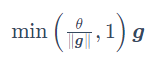

的L2范数不超过θ。

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)


## 6. 困惑度
我们通常使用困惑度（perplexity）来评价语言模型的好坏。回忆一下3.4节（softmax回归）中交叉熵损失函数的定义。困惑度是对交叉熵损失函数做指数运算后得到的值。特别地，
1. 最佳情况下，模型总是把标签类别的概率预测为1，此时困惑度为1；
2. 最坏情况下，模型总是把标签类别的概率预测为0，此时困惑度为正无穷；
3. 基线情况下，模型总是预测所有类别的概率都相同，此时困惑度为类别个数。
显然，任何一个有效模型的困惑度必须小于类别个数。在本例中，困惑度必须小于词典大小vocab_size。

## 7. 定义模型训练函数
跟之前章节的模型训练函数相比，这里的模型训练函数有以下几点不同：
1. 使用困惑度评价模型。
2. 在迭代模型参数前裁剪梯度。
3. 对时序数据采用不同采样方法将导致隐藏状态初始化的不同。相关讨论可参考6.3节（语言模型数据集（周杰伦专辑歌词））。
另外，考虑到后面将介绍的其他循环神经网络，为了更通用，这里的函数实现更长一些。

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    if is_random_iter:
        data_iter_fn = d2l.data_iter_random
    else:
        data_iter_fn = d2l.data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:  
            # 否则需要使用detach函数从计算图分离隐藏状态, 这是为了
            # 使模型参数的梯度计算只依赖一次迭代读取的小批量序列(防止梯度计算开销太大)
                for s in state:
                    s.detach_()

            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成长度为
            # batch * num_steps 的向量，这样跟输出的行一一对应
            y = torch.transpose(Y, 0, 1).contiguous().view(-1)
            # 使用交叉熵损失计算平均分类误差
            l = loss(outputs, y.long())

            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            d2l.sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))


## 8.训练模型并且创作歌词
现在我们可以训练模型了。首先，设置模型超参数。我们将根据前缀“分开”和“不分开”分别创作长度为50个字符（不考虑前缀长度）的一段歌词。我们每过50个迭代周期便根据当前训练的模型创作一段歌词。

In [ ]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 500, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '明天', '中国']


In [ ]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


epoch 50, perplexity 66.344651, time 0.10 sec
 - 分开 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我
 - 明天 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我
 - 中国 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我不要再想 我
epoch 100, perplexity 10.276022, time 0.10 sec
 - 分开 不要再双 习谁了空 恨一定空 你不着  你的你空 我想多 爱你我 看想就 我给就这样牵 你知想好样
 - 明天 我不能 想爱走著 快些有 你想我 说你   你的回头 我想要这样  没有你在我有多 从小就耳 我来
 - 中国 不着用双 习使用双截棍 哼哼哈兮 快使用双截棍 哼哼哈兮 如果我有轻功  我不要看里 我不能 想你
epoch 150, perplexity 2.855509, time 0.10 sec
 - 分开 娘子我 别地安 三壶四头 江人 一壶么 有在回 干什么纳霜 在唱盘 旧皮箱 装属了明信片的铁盒里藏
 - 明天 我不能 穿爱我 让我 恨你的事我早红 却因 没有你的玩笑 像通法重 让你的 不人光 什么都有 一漠
 - 中国对 周只人年酿的 有什的传女人  在穿了明我 一地莫 担怪箱 装属了明信片的铁盒 藏著一容次剧 也上
epoch 200, perplexity 1.612630, time 0.10 sec
 - 分开 不想去用分直 有多抢靠我 轻学是乌鸦 别人掌怕羞 蜥蝪横著走 这里什么奇怪的事都有 包括像猫的狗 
 - 明天那我说那了透那 我给你的爱写在西元前 深埋在美索不达米亚平原 几十个文纪后出土发现 泥板上的字迹依然
 - 中国记 风姥人年酿的豆瓣酱 我对著黑白照片开始想像 爸和妈当年的模样 说著一口吴侬 语上完斤在排肉轻 还
epoch 250, perplexity 1.316153, time 0.10 sec
 - 分开 装么的欢干 谁都盘停留的忧为还 我对著黑白照片开始想像 爸和妈当年的模样 说著一口吴侬软语的姑娘缓
 - 明天那手心边 我说得的让写有西元前 深埋在美索不达米亚平原 几十个世纪后出土